# ToF Filtering to Maximize Sensitivity
Numerical verification(using simulation data) of my optimization derivation. The formula states that sensitivity can be maximized if we maximize the following term wrt the integration limits
$$
\frac{\int I(L) |log(R(L))|}{\int I(L)} dL
$$

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from inverse_modelling_tfo.tools.name_decoder import decode_extended_filename
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2
from inverse_modelling_tfo.tools.optical_properties import get_tissue_mu_a
from tfo_sensitivity.data import load_raw
from tfo_sensitivity.tof import ToF, two_pointer_discrete_optimize, two_pointer_brute_force_optimize

wave_int = 2
data_path = r'/home/rraiyan/simulations/tfo_sim/data/dan_iccps_pencil/fa_pulse_wv_2_sa_0.1_ns_1_ms_4_ut_5.pkl'
raw_sim_data = pd.read_pickle(data_path)
# Create SDD column!
raw_sim_data['SDD'] = raw_sim_data['X'] - raw_sim_data['Y']
all_sdd = raw_sim_data['SDD'].unique()

In [3]:
MATERNAL_Hb = 11.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.50
FETAL_Hb = 11.0
DELTA = 0.01
SDD_index = 1
BLOOD_VOLUME_FRACTION = 0.1

data_table = pd.DataFrame(columns=['Saturation', 'Derivative', 'SDD', 'Type'])
all_c = np.arange(0.1, 1.5, 0.1)
all_fetal_sat = np.arange(0.1, 0.65, 0.2)
base_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2

modified_mu_map_base = base_mu_map.copy()
modified_mu_map_base[1] = get_tissue_mu_a(BLOOD_VOLUME_FRACTION, MATERNAL_SAT, MATERNAL_Hb, wave_int)
modified_mu_map_base[4] = get_tissue_mu_a(BLOOD_VOLUME_FRACTION, FETAL_SAT, FETAL_Hb, wave_int)

modified_mu_map_increased = base_mu_map.copy()
modified_mu_map_increased[1] = get_tissue_mu_a(BLOOD_VOLUME_FRACTION, MATERNAL_SAT, MATERNAL_Hb, wave_int)
# modified_mu_map_increased[4] = get_tissue_mu_a(BLOOD_VOLUME_FRACTION, FETAL_SAT + DELTA, FETAL_Hb, wave_int)
modified_mu_map_increased[4] = get_tissue_mu_a(BLOOD_VOLUME_FRACTION, FETAL_SAT , FETAL_Hb + DELTA, wave_int)

data_table = pd.DataFrame(columns=['Derivative', 'SDD', 'I'])

filtered_photon_data  = (raw_sim_data[raw_sim_data["SDD"] == all_sdd[SDD_index]]).copy()

In [4]:
# Use the new brute force optimization instead. The two pointer one sometimes gets stuck at a local optima
TIME_RESOLUTION = 0.2e-9
lower_intensity_bound = 1e-30
tof_base = ToF(filtered_photon_data, TIME_RESOLUTION, modified_mu_map_base, SDD_index, lower_intensity_bound)
tof_increased = ToF(filtered_photon_data, TIME_RESOLUTION, modified_mu_map_increased, SDD_index, lower_intensity_bound)

Total Photons Captured in RAW sim data 10256582.442472722
Total Photons in RAW sim data 10258560


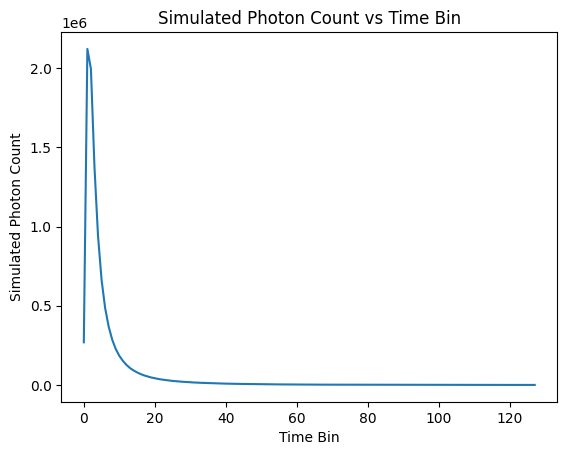

In [8]:
plt.figure()
plt.plot(tof_base.photon_count_per_bin)
plt.xlabel('Time Bin')
plt.ylabel('Simulated Photon Count')
plt.title('Simulated Photon Count vs Time Bin')
print("Total Photons Captured in RAW sim data", tof_base.photon_count_per_bin.sum())
print("Total Photons in RAW sim data", len(filtered_photon_data))

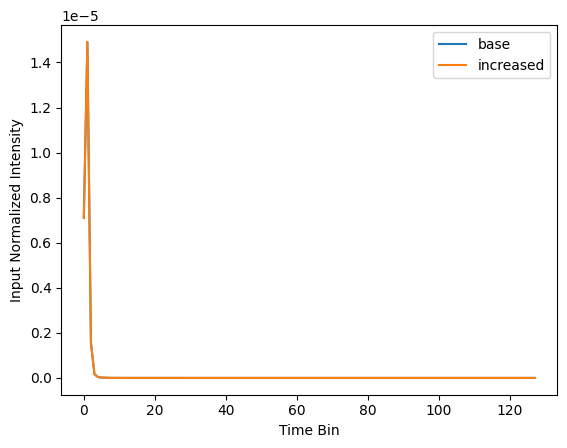

In [ ]:
plt.plot(tof_base.data, label='base')
plt.plot(tof_increased.data, label='increased')
plt.xlabel('Time Bin')
plt.ylabel('Input Normalized Intensity')
plt.legend()

# Defining the Target Function

In [15]:
# Note: Operator overloading takes care of bin count mismatch/missing bins etc. When working with two ToF, its better to use the overloaded operators
RL = tof_base / tof_increased
numerator = np.abs(np.log(RL.data)) * tof_base.data
denominator = tof_base.data

# target_func = lambda left, right: numerator.iloc[left: right + 1].sum() / denominator.iloc[left: right + 1].sum() * (right - left + 1)**(1/2)
# target_func = lambda left, right: numerator.iloc[left: right + 1].sum() 
# target_func = lambda left, right: numerator.iloc[left: right + 1].sum() / denominator.iloc[left: right + 1].sum()
target_func = lambda left, right: numerator.iloc[left: right + 1].sum() / denominator.iloc[left: right + 1].sum() + tof_base.photon_count_per_bin.iloc[left: right + 1].sum() / tof_base.photon_count_per_bin.sum()

# left, right, optimum = two_pointer_discrete_optimize(target_func, 0, len(tof_base.data) - 1, "max")
left, right, optimum = two_pointer_brute_force_optimize(target_func, 0, len(tof_base.data) - 1, "max")
print("Data Length", len(numerator))

# print("RL data", RL.data)
print(left, right, optimum)

Data Length 128
0 127 1.0000047629418938


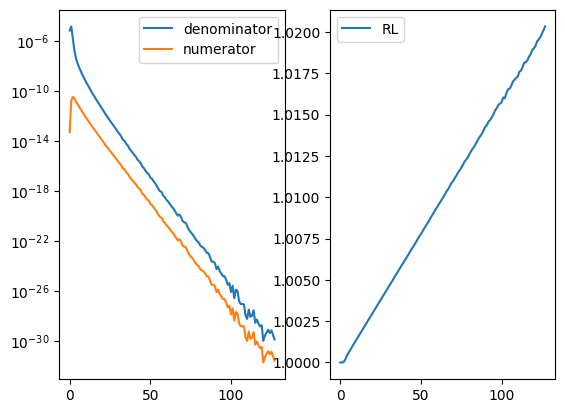

In [16]:
fig, ax = plt.subplots(1, 2)

plt.sca(ax[0])
plt.plot(denominator, label='denominator')
plt.plot(numerator, label='numerator')
plt.yscale('log')
plt.legend()

plt.sca(ax[1])
plt.plot(RL.data, label='RL')
plt.legend()

In [17]:
# # Note: Operator overloading takes care of bin count mismatch/missing bins etc. When working with two ToF, its better to use the overloaded operators
# target_func = lambda left, right: (tof_base.data.iloc[left: right + 1].sum() - tof_increased.data.iloc[left: right + 1].sum()) / tof_base.data.iloc[left: right + 1].sum()

# # left, right, optimum = two_pointer_discrete_optimize(target_func, 0, len(tof_base.data) - 1, "max")
# left, right, optimum = two_pointer_brute_force_optimize(target_func, 0, len(tof_base.data) - 1, "max")
# print("Data Length", len(tof_base.data))
# print(left, right, optimum)

# Plotting Heatmap

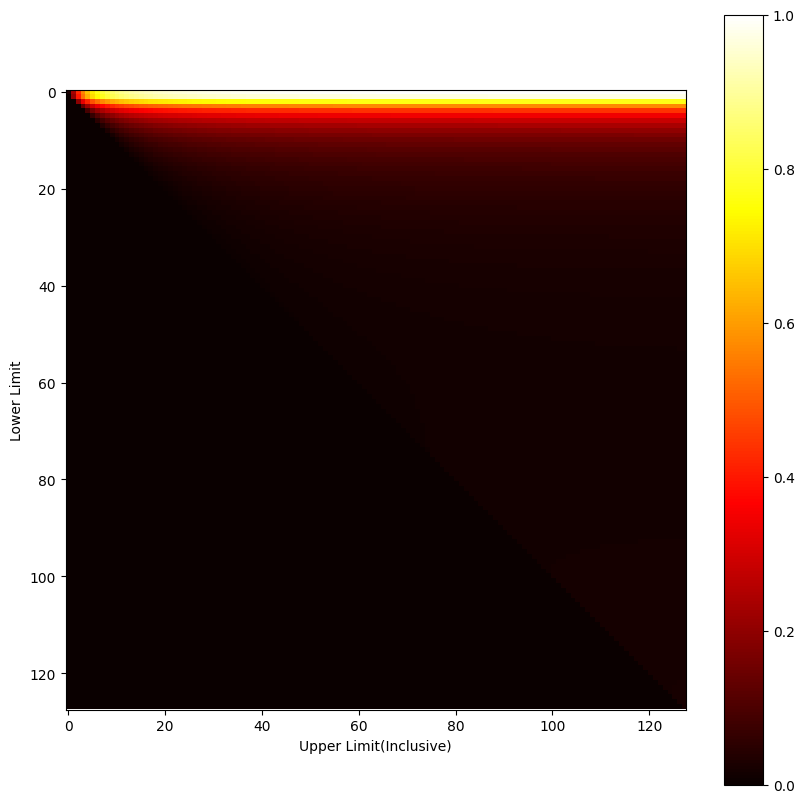

In [18]:
# Brute Force Optimization
plt.figure(figsize=(10, 10))
target_func_matrix = np.zeros((len(tof_base.data), len(tof_base.data)))
for i in range(len(tof_base.data)):
    for j in range(i, len(tof_base.data)):
        target_func_matrix[i, j] = target_func(i, j)
# target_func_matrix = np.abs(np.log(target_func_matrix))
plt.imshow(target_func_matrix, cmap='hot', interpolation='none')
plt.xlabel('Upper Limit(Inclusive)')
plt.ylabel('Lower Limit')
plt.colorbar()